In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import random
import folium
import pyproj
import numpy as np
import requests
import shapely.geometry
import os
import pandas as pd
import glob
from IPython.display import clear_output
from datetime import timedelta
import time
# Some new libraries: they should already
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import box, Point, LineString
import spaghetti
import math
import pyproj
import esda
import seaborn as sns

/home/k21195339/.local/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the distance (in meters) between two points on the Earth's surface
    given their latitude and longitude coordinates using the Haversine formula.
    """
    R = 6371000  # radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))

    return R*c

In [3]:
# Checks to see if a point (lat, lon) is in a bounding box (N, S, E, W)
def point_in_bbox(point):
    N, S, E, W = leeds_bbox
    lat, lon = point 

    if N >= lat >= S and E >= lon >= W:
        return True
    else:
        return False

## Task A (spatial networks and planarity):

In this task, you construct and investigate the road network. You are asked to choose an area of roughly 1 square kilometre around the centre of Leeds for your analysis. You should look for an area where a significant number of the recorded road accidents occurred in the area, e.g. 300 or more total across multiple years, and show you have tested this in your report. You only need to consider roads used for driving, not walking paths or private roads (investigate the osmnx documentation for how you might do this filtering). Your report should give the coordinates of the area chosen. You should then answer the following questions:

1.     What are the characteristics of this road network? Include, at least, the spatial diameter of the network, the average street length, node density, intersection density, and edge density.

2.     What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?

3.     Is the network planar? Why/why not?

### Generating the graph

In [4]:
center_lat = 53.802035
center_lon = -1.537810

# Define the center point of Leeds
leeds_center = (center_lat, center_lon)

# Create the graph for Leeds city center
leeds_graph = ox.graph.graph_from_point(leeds_center, dist=500, dist_type='bbox', network_type='drive')

# Get the bounding box
leeds_bbox = ox.utils_geo.bbox_from_point(leeds_center, dist=500)

# Create a polygon - use it later
leeds_polygon = ox.utils_geo.bbox_to_poly(leeds_bbox[0], leeds_bbox[1], leeds_bbox[2], leeds_bbox[3])

# Find the Area
base = haversine(leeds_bbox[0], leeds_bbox[2], leeds_bbox[0], leeds_bbox[3])
height = haversine(leeds_bbox[0], leeds_bbox[3], leeds_bbox[1], leeds_bbox[3])
leeds_area = base*height

#### Plotting our Graph

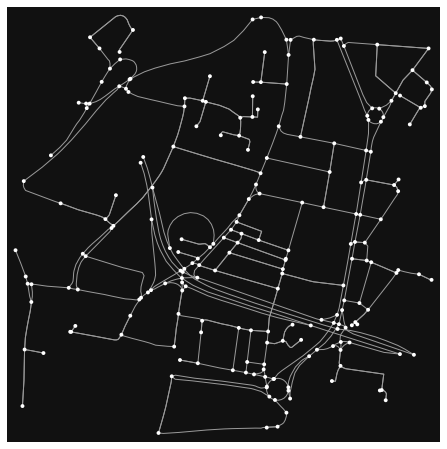

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
ox.plot_graph(leeds_graph)

In [6]:
ox.plot_graph_folium(leeds_graph)

### Calculating Basic Stats about the Network

#### First, Easy Stats
- Average Street Length
- Node Density
- Intersection Density
- Edge Density

In [7]:
# Calculate Basic Stats
basic_stats = ox.stats.basic_stats(leeds_graph, area=leeds_area)

# Node and edge data
print("There are {} nodes and {} edges in this graph".format(basic_stats["n"], basic_stats["m"]))

# Average Street Length
print("Average street length: {}m".format(round(basic_stats["street_length_avg"], 2)))

# Node Density
print("Node density of {} nodes per square km".format(round(basic_stats["node_density_km"], 2)))

# Intersection Density
print("Intersection density of {} intersections per square km".format(basic_stats["intersection_count"]))

# Edge Density
print("Edge density of {} edges per square km".format(round(basic_stats["edge_density_km"], 2)))

There are 217 nodes and 386 edges in this graph
Average street length: 65.49m
Node density of 217.02 nodes per square km
Intersection density of 190 intersections per square km
Edge density of 24580.4 edges per square km


In [8]:
basic_stats

{'n': 217,
 'm': 386,
 'k_avg': 3.557603686635945,
 'edge_length_total': 24577.693000000014,
 'edge_length_avg': 63.67277979274615,
 'streets_per_node_avg': 2.8202764976958523,
 'streets_per_node_counts': {0: 0, 1: 27, 2: 12, 3: 151, 4: 27},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.12442396313364056,
  2: 0.055299539170506916,
  3: 0.695852534562212,
  4: 0.12442396313364056},
 'intersection_count': 190,
 'street_length_total': 18731.113000000005,
 'street_segment_count': 286,
 'street_length_avg': 65.49340209790212,
 'circuity_avg': 1.0303846733857918,
 'self_loop_proportion': 0.0,
 'node_density_km': 217.02388738340684,
 'intersection_density_km': 190.02091522049446,
 'edge_density_km': 24580.39851509654,
 'street_density_km': 18733.174922939488}

#### Spatial Diameter

In [9]:
# Compute extended network statistics, including spatial diameter
spatial_diameter = ox.extended_stats(leeds_graph, ecc=True, bc=True, cc=True)['diameter']

# Print the spatial diameter
print("Spatial diameter of the network is: {} meters".format(round(spatial_diameter, 2)))

/home/k21195339/.local/lib/python3.8/site-packages/osmnx/stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


Spatial diameter of the network is: 2608.84 meters


#### Planarity

In [10]:
is_planar, kuratowski_subgraphs = nx.check_planarity(leeds_graph, counterexample=True)
if is_planar:
    print("Planar")
else:
    print("Not Planar")

Not Planar


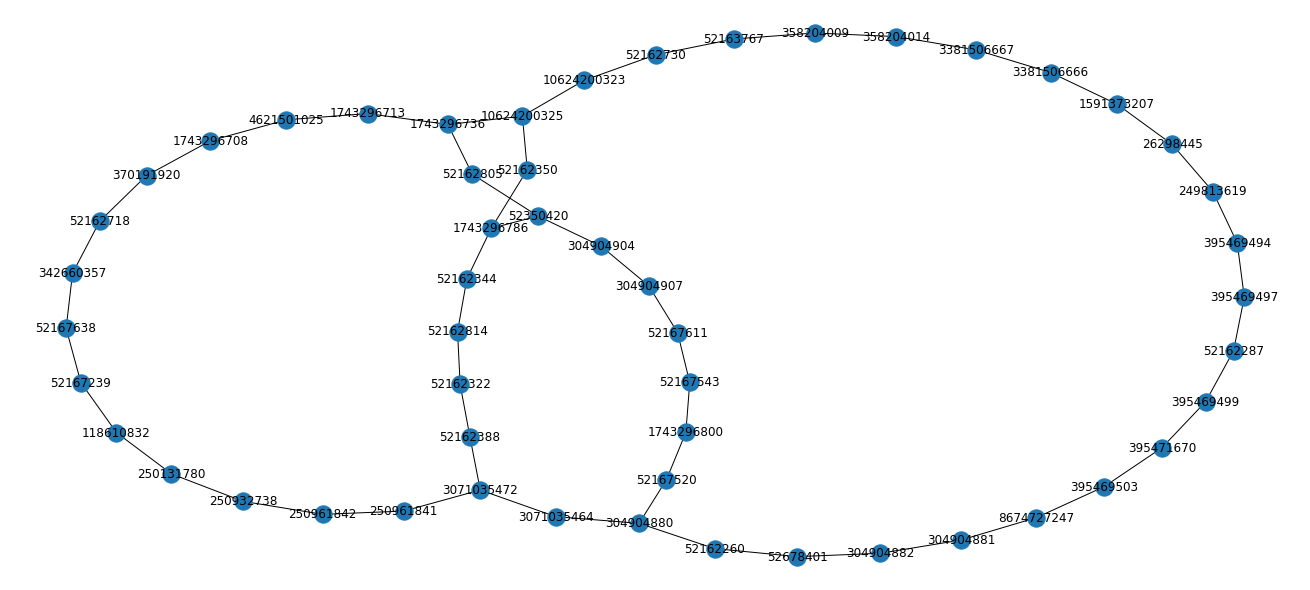

In [11]:
plt.figure(figsize=(18, 8))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, arrowstyle='-|>', with_labels=True)
plt.show()

## Task B (Road Accidents):

In this task, you should investigate the road accidents on the road network.

1.     Plot the distribution of road accidents on your road network and visualise this. Aggregate across multiple years of accident data. You do not need to consider or represent when the accidents happened, only their location; but you are welcome to add information about time if you believe there is something interesting to show.

2.     Investigate whether a high number of accidents on one road correlates with a high number on connecting roads.

3.     Investigate whether accidents happen nearer to intersections or partway along roads. Consider this as asking at what fraction of the road length away from the nearest intersection do accidents typically occur.

For the above, we suggest using the spaghetti library as shown in your lessons. The third question will require investigating the API of the library to find the relevant functions to answer the question.

### Loading and cleaning the Data

#### Accident Data
- Initally load accident data
- Rename column to "Accident Year"

In [12]:
ACCIDENTS_DIR = "data"  # Assumes that the crime data is located in the 'data' subfolder
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing', 'Accident Date']  # Only use these columns

# Load all CSV files in the 'data' subfolders into a single dataframe
years_df = []
for path, subdir, _ in os.walk(ACCIDENTS_DIR):
    for csv_file in glob.glob(os.path.join(path, "*.csv")):
        year_df = pd.read_csv(csv_file, usecols=USE_COLS, encoding='iso-8859-1')
        years_df.append(year_df)

accidents_df = pd.concat(years_df, axis=0, ignore_index=True)
print("Found {} CSV files in '{}', total no. of accidents loaded: {}"
      .format(len(years_df), ACCIDENTS_DIR, len(accidents_df)))

# Filter out accidents that do not have a location (missing latitude or longitude)
located_accidents = accidents_df.dropna(subset=['Grid Ref: Easting', 'Grid Ref: Northing'])
print("Total no. of located accidents: {}".format(len(located_accidents)))

Found 7 CSV files in 'data', total no. of accidents loaded: 16284
Total no. of located accidents: 16284


In [13]:
located_accidents.rename(columns={"Accident Date": "Accident Year"}, inplace=True)
located_accidents['Accident Year'] = ('20' + located_accidents['Accident Year'].str[-2:]).astype(int)  
located_accidents.sort_values(by="Accident Year", inplace=True)
located_accidents

,Grid Ref: Easting,Grid Ref: Northing,Accident Year
7165,430104,433928,2013
6011,419870,438909,2013
6010,427984,435224,2013
6009,429832,438889,2013
6008,420676,445078,2013
...,...,...,...
8908,428804,433315,2019
8909,431402,435029,2019
8910,441099,432504,2019
8898,429962,430875,2019


#### Transforming to GeoDataFrame
- Defining the different Coordinate Reference Systems (CRS)
- Transform the data from BNG -> WGS 84
- then we check whether the points are within our bounding box
- Drop those which are not in the bounding box

In [14]:
#Translate to a GeoDataFrame where the geometry is given by a Point constructed from the longitude and latitude
geometry = [Point(xy) for xy in zip(located_accidents["Grid Ref: Easting"], located_accidents["Grid Ref: Northing"])]
accident_points = GeoDataFrame(located_accidents["Accident Year"], geometry=geometry)

# Define the input and output CRS
input_crs = "EPSG:27700"  # BNG
output_crs = "EPSG:4326"  # WGS 84, the most common CRS for latitude and longitude

# Create a PyProj transformer to convert between the CRSs
transformer = pyproj.Transformer.from_crs(input_crs, output_crs)

# Apply the transformer to the POINT geometry column
accident_points["lonlat"] = accident_points["geometry"].apply(lambda geom: transformer.transform(geom.x, geom.y))

# Replace the "geometry" column with the new "lonlat" column
accident_points["geometry"] = accident_points["lonlat"].apply(lambda lonlat: Point(lonlat[1], lonlat[0]))

# Apply a function to check whether each point is within a bounding box
accident_points["in_bbox"] = accident_points["lonlat"].apply(point_in_bbox)

# Filter out points outside the bounding box, drop the "lonlat" column, and sort by year
leeds_accidents = accident_points[accident_points["in_bbox"]].drop(columns=["lonlat"]).sort_values(by="Accident Year")

leeds_accidents

,Accident Year,geometry,in_bbox
7165,2013,POINT (-1.54442 53.80079),True
7595,2013,POINT (-1.54269 53.80472),True
7571,2013,POINT (-1.53502 53.79921),True
7580,2013,POINT (-1.53970 53.79939),True
7576,2013,POINT (-1.53038 53.80591),True
...,...,...,...
7719,2019,POINT (-1.54329 53.80076),True
7699,2019,POINT (-1.54493 53.80510),True
8070,2019,POINT (-1.53335 53.80102),True
8346,2019,POINT (-1.53330 53.80124),True


### Generating a Spaghetti Network for Analysis
- The code creates a geometry attribute for each edge in the network that does not already have one, by assuming that the road is a direct line from start point to end point.
- The code drops the start and end nodes of the network and constructs a new Spaghetti network based on the geometries of the roads, which can be used to perform point analysis.

roads_geodataframe

#### Graph for Visualisation

<AxesSubplot:>

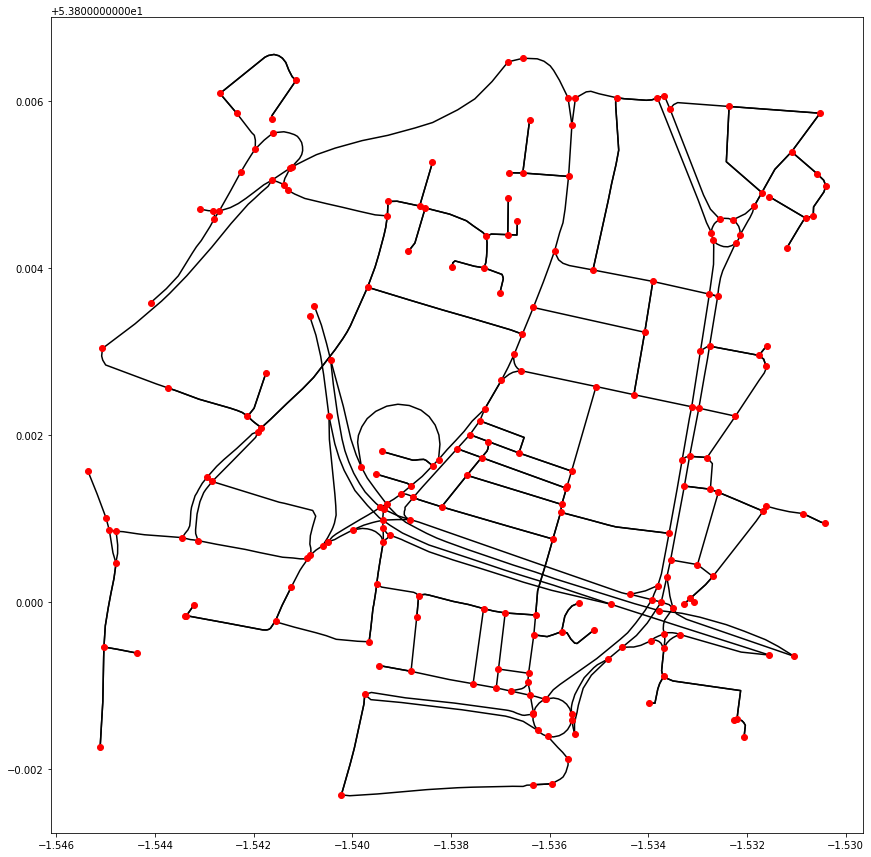

In [15]:
# Convert the Leeds street network graph into two GeoDataFrames for nodes and edges
nodes_df, edges_df = ox.graph_to_gdfs(leeds_graph)

# Generate a Spaghetti Network from the edges DataFrame
leeds_points_graph = spaghetti.Network(in_data=edges_df)

# Plot the edges of the network as black lines on a new figure with a size of 15x15 inches and a default Z-order of 0
base_network = edges_df.plot(color="k", zorder=0, figsize=(15, 15))

# Plot the nodes of the network as red dots on the same figure with a Z-order of 2 (i.e., on top of the edges)
nodes_df.plot(ax=base_network, color="r", zorder=2)

# Generate a Spaghetti Network from the edges DataFrame

#### Snapping points to Spaghetti Network

In [16]:
# We will now snap the accident we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accidents, 'accidents')

# We can see the difference between the original accident coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

/home/k21195339/.local/lib/python3.8/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/k21195339/.local/lib/python3.8/site-packages/libpysal/cg/shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/k21195339/.local/lib/python3.8/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


observation 1
true coords:	(-1.5444171895231136, 53.80078843899443)
snapped coords:	(-1.5444143927357115, 53.80082030707588)


### Visualisation of the Data
- We initially present a graph of the snapped accidents
- A second graph contains the unsnapped accidents
- A third graph shows the kde density function of the accidents

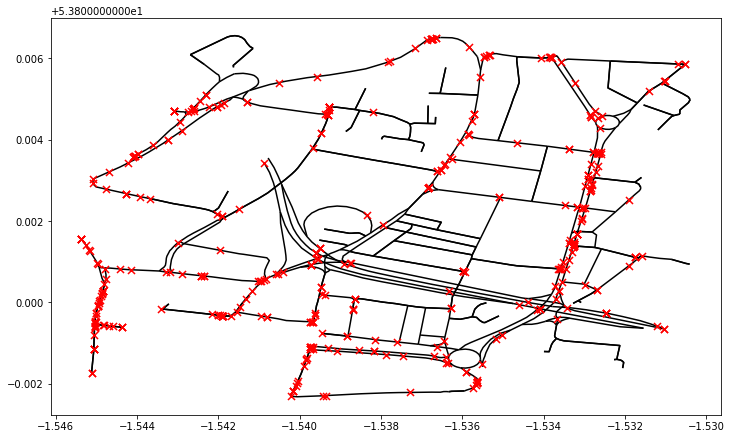

In [17]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

<AxesSubplot:>

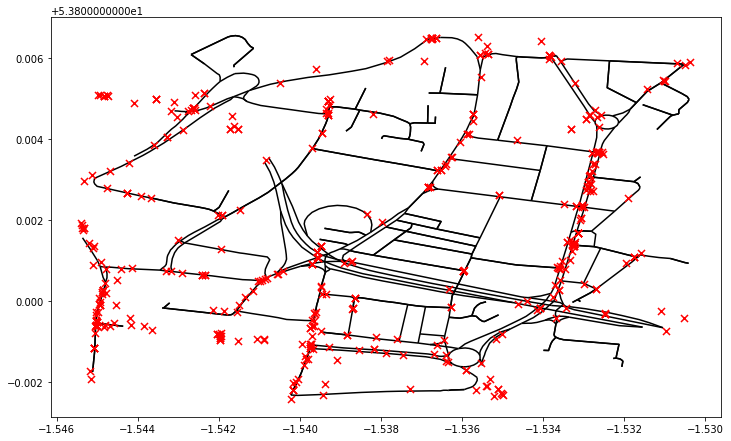

In [18]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

# plt.savefig('crime_observations_unsnapped')

/home/k21195339/.local/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


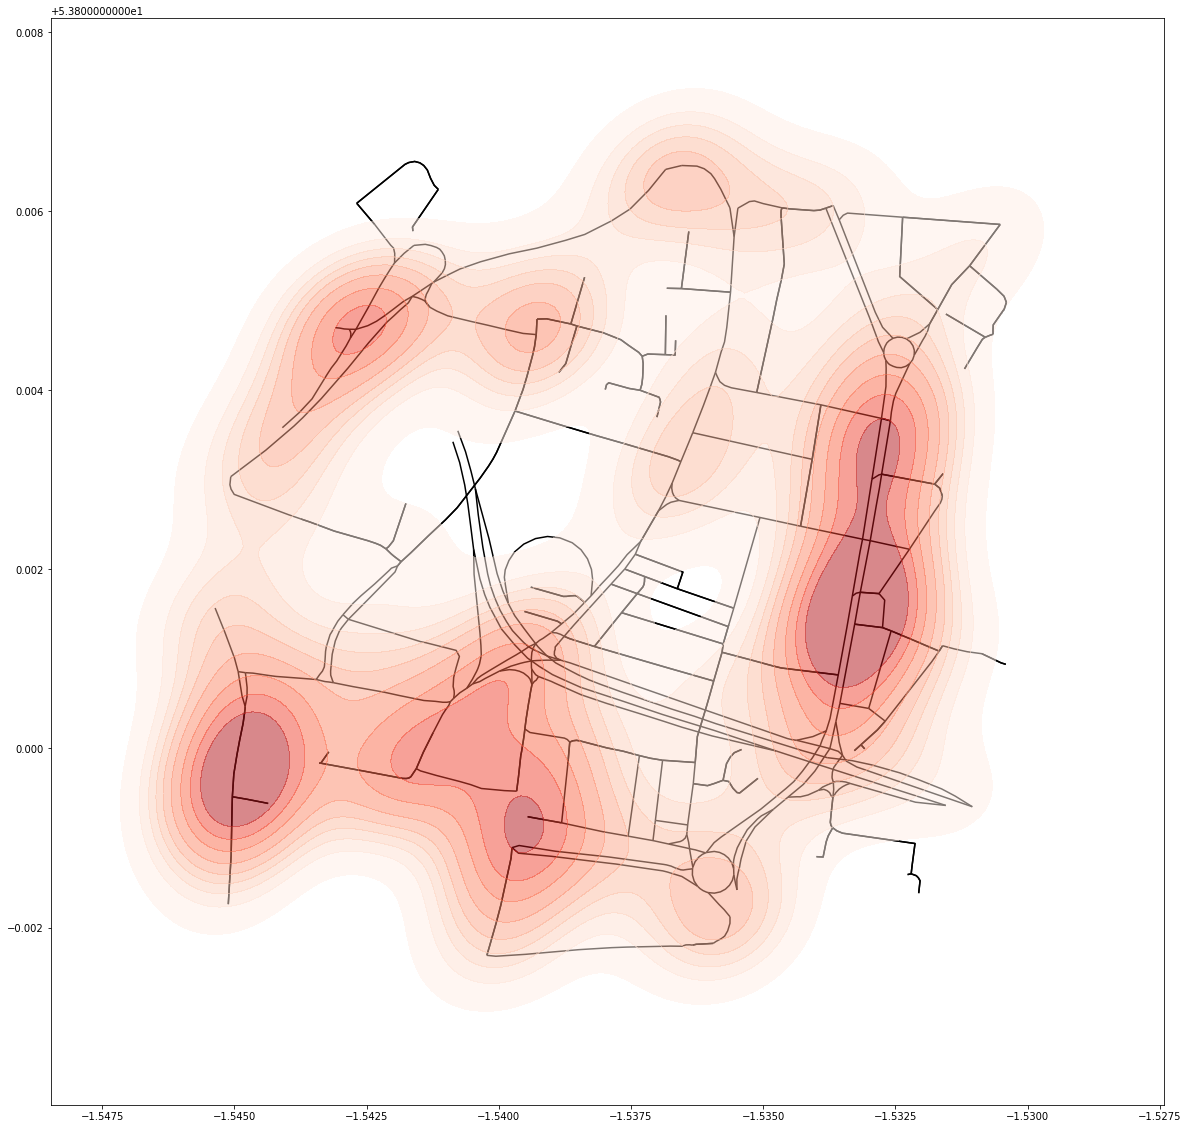

In [19]:
# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(20,20))

# Plot a KDE heatmap of the snapped accidents on the road network
# Increase sensitivity of the heatmap by decreasing the bandwidth
sns.kdeplot(
    x=snapped_accidents.geometry.x,
    y=snapped_accidents.geometry.y,
    cmap='Reds',
    shade=True,
    shade_lowest=False,
    alpha=0.5,
    ax=ax,
    bw_adjust=0.65  # Change this value to adjust the bandwidth
)

# Show the network on the same axes object
edges_df.plot(color="k", zorder=0, ax=ax)

# Display the plot
plt.show()

### A more in Depth Analysis
- Trying to answer whether a high number of accidents on one road correlates with a high number on connecting roads.
- Additionally, we want to know whether accidents happen nearer to intersections or partway along roads.
- Consider this as asking at what fraction of the road length away from the nearest intersection do accidents typically occur.

- We use Morans I to identify Spatial autocorrelation
- We also use Global Auto K-Function analysis to identify whether ther is some clustering occuring

#### Ripley's K function
- Checks if there is clustering as each step increases
- We can also get the upper and lower bound
- Spatial randomness we would expect to see in lower and upper bounds

In [20]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=50, permutations=100
)

In [21]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 1959.0512646311574


In [22]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.0004222  0.0008444  0.00126659 0.00168879 0.00211099
 0.00253319 0.00295538 0.00337758 0.00379978 0.00422198 0.00464417
 0.00506637 0.00548857 0.00591077 0.00633296 0.00675516 0.00717736
 0.00759956 0.00802175 0.00844395 0.00886615 0.00928835 0.00971054
 0.01013274 0.01055494 0.01097714 0.01139933 0.01182153 0.01224373
 0.01266593 0.01308812 0.01351032 0.01393252 0.01435472 0.01477691
 0.01519911 0.01562131 0.01604351 0.01646571 0.0168879  0.0173101
 0.0177323  0.0181545  0.01857669 0.01899889 0.01942109 0.01984329
 0.02026548 0.02068768]


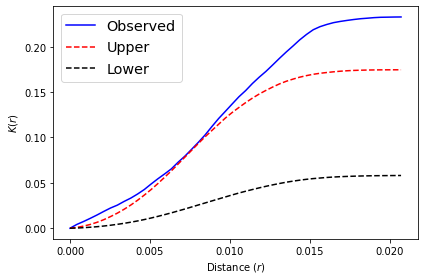

In [23]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

In [24]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)
counts

{(711, 712): 1,
 (235, 830): 7,
 (33, 799): 1,
 (174, 175): 5,
 (67, 68): 5,
 (619, 903): 2,
 (91, 709): 2,
 (173, 844): 2,
 (122, 956): 5,
 (152, 843): 2,
 (976, 977): 6,
 (342, 343): 3,
 (54, 981): 3,
 (121, 122): 2,
 (524, 525): 3,
 (47, 48): 3,
 (488, 489): 1,
 (652, 653): 2,
 (858, 859): 1,
 (53, 285): 4,
 (529, 672): 5,
 (166, 550): 2,
 (116, 117): 1,
 (698, 699): 7,
 (775, 776): 6,
 (957, 958): 4,
 (606, 607): 2,
 (615, 616): 2,
 (781, 782): 3,
 (549, 551): 2,
 (190, 194): 1,
 (732, 733): 3,
 (697, 698): 1,
 (577, 578): 1,
 (618, 619): 1,
 (261, 918): 1,
 (167, 857): 2,
 (288, 289): 3,
 (983, 984): 2,
 (119, 120): 1,
 (75, 182): 1,
 (963, 964): 1,
 (42, 155): 5,
 (887, 888): 1,
 (431, 432): 1,
 (708, 709): 1,
 (617, 622): 3,
 (529, 657): 6,
 (566, 567): 1,
 (962, 982): 1,
 (265, 266): 1,
 (960, 961): 5,
 (58, 641): 2,
 (125, 974): 1,
 (959, 960): 1,
 (203, 603): 3,
 (136, 137): 3,
 (122, 963): 4,
 (480, 609): 9,
 (219, 220): 2,
 (82, 83): 13,
 (298, 299): 1,
 (253, 254): 1,
 (96

In [25]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

In [26]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [27]:
moran = esda.moran.Moran(values, weights)
moran.I

0.1242845669590101

In [28]:
moran.p_sim

0.003

In [29]:
moran.EI
moran.EI_sim

print(moran.EI)

-0.0009372071227741331


Text(0.5, 0, "Moran's I")

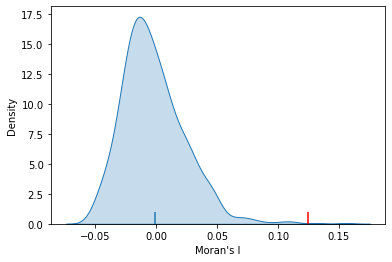

In [30]:
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

In [31]:
moran.z_norm

4.423455239311521

In [32]:
moran.z_sim

4.826455727351857

In [33]:
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

## Task C (Voronoi diagrams):

Despite its accidents, the city of Leeds is ideal for organising marathons. The city major would like to organise a day of parallel, simultaneous marathons in different parts of the city. The major would like to maximise the participation of citizens by organising these marathons in diverse locations of the city, dividing the city into various areas (or “cells”) so that every person can join a marathon that is close to their home. Within each of these cells, a path of exactly 42 Km is needed. Assuming that the mayor would like to organise N=10 simultaneous marathons:

1.     Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc. (explain your choice in the report).

2.     Visualise the cells yield by your selection of seed points in a Voronoi diagram

3.     Find 2 or 3 cells for which you can find at least one path (or more, if possible) that is (a) exactly 42 Km long, and (b) finishes at the same point where it starts. Visualise both the cells and the found paths.

4.     Try to extend the previous step to all cells. Can you find at least one such a path for every cell?

5.     If for steps 3-4 there were cells with no such path, what different options could you consider to increase the number of cells that include such paths? (Hint: think about the number and location of seed points; the size of the area under consideration; etc.) Choose one of such options, repeat steps 3-4, and report the results you obtain, explaining your reasoning in the report.

In [34]:
# City with larger size
query_place = 'Leeds, United Kingdom'
full_leeds_graph = ox.graph_from_place(query_place, network_type="all")

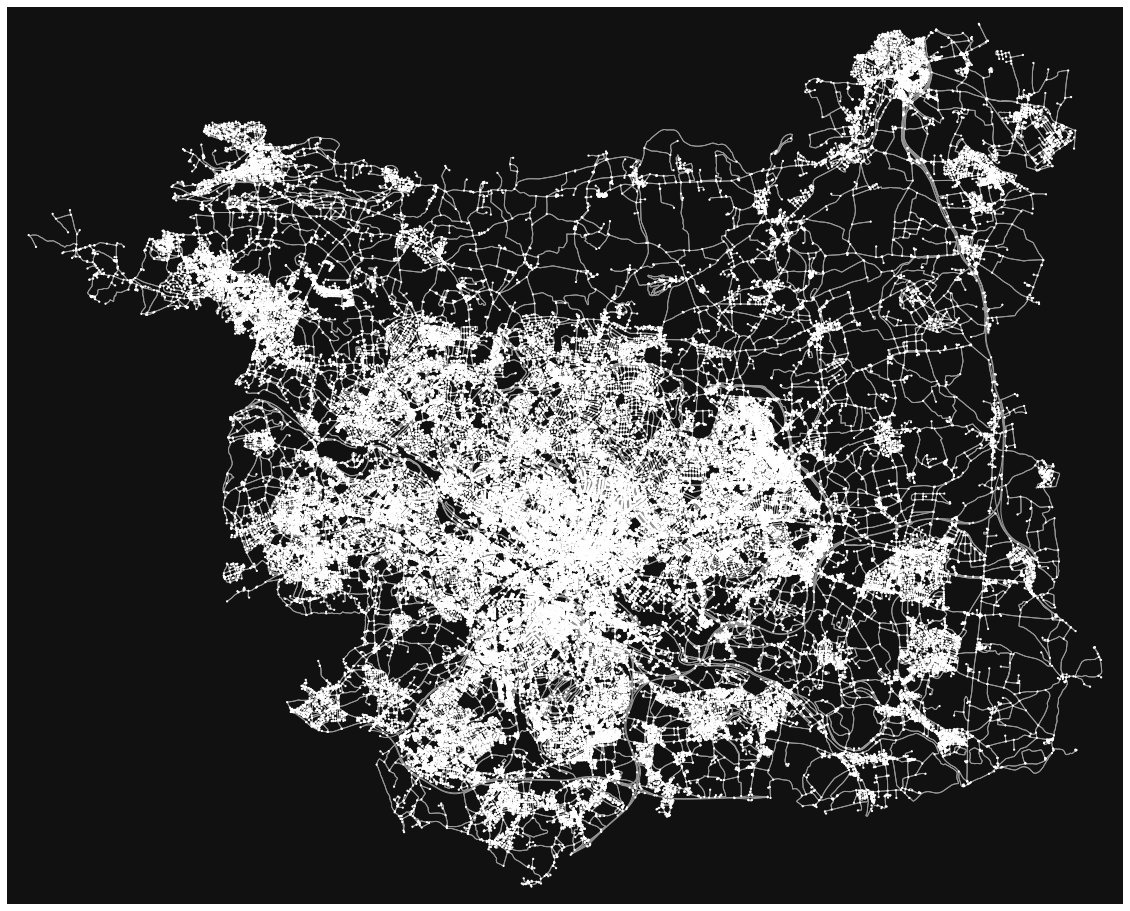

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [35]:
# graph_project = ox.project_graph(query_place_graph)
ox.plot_graph(full_leeds_graph, figsize=(20,20), node_size=5)

In [74]:
NUMBER_OF_SEEDS = 10

all_nodes = set(full_leeds_graph.nodes)
seeds = random.choices(list(all_nodes), k=NUMBER_OF_SEEDS)

In [75]:
colours = ox.plot.get_colors(NUMBER_OF_SEEDS)

def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

def nearest_seed(node, dist, seeds, cache={}):
    if node in cache:
        return cache[node]
    seed_distances = [(seed, dist[seed][node]) for seed in seeds if node in dist[seed]]
    nearest = nearest_from_list(seed_distances)
    cache[node] = nearest
    return nearest

def nearest_for_edge(edge, dist, seeds):
    nearest_to_ends_all = [nearest_seed(edge[0], dist, seeds), nearest_seed(edge[1], dist, seeds)]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

def colour_for_seed_distance(seed):
    if seed and seed[0] in seeds:
        return colours[seeds.index(seed[0])]
    else:
        return 'k'  # Return black color for edges not connected to any seed

In [76]:
def print_voronoi_graph(G, seeds):
    distances = {seed: nx.single_source_dijkstra_path_length(G, seed, weight='length') for seed in seeds}
    
    edge_nearest_seeds = [nearest_for_edge(edge, distances, seeds) for edge in G.edges]
    # Note that edges not connected to a seed shown in black, so invisible on black background
    edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
    # For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
    node_colours = ['r' if node in seeds else 'w' for node in all_nodes]
    node_sizes = [30 if node in seeds else 0 for node in all_nodes]
    
    ox.plot.plot_graph(full_leeds_graph, figsize=(20,20), edge_color = edge_colours, node_size = node_sizes, node_color = node_colours, bgcolor = 'k', save = True, filepath = 'nvd.png')

/home/k21195339/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


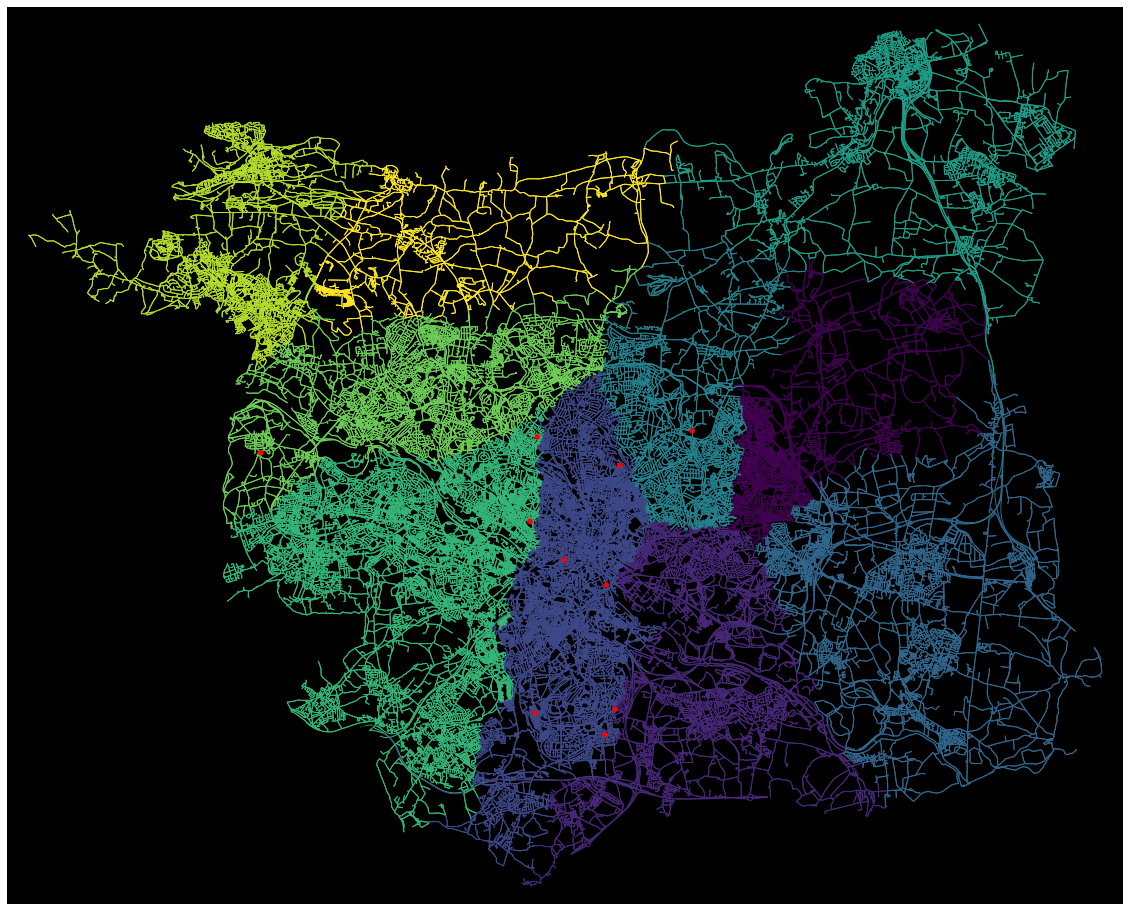

In [77]:
print_voronoi_graph(full_leeds_graph, seeds)

In [71]:
# Load the OSMnx graph data for your area of interest
G = full_leeds_graph

# Create a list of all nodes in the graph
all_nodes = list(G.nodes())
# Randomly select the first seed node
seeds = [np.random.choice(all_nodes)]

# Continue randomly selecting seeds until we have enough
while len(seeds) < NUMBER_OF_SEEDS:
    # Calculate the minimum distance from each node to the existing seed nodes
    distances = []
    for node in all_nodes:
        min_distance = np.inf
        for seed in seeds:
            distance = ox.distance.euclidean_dist_vec(G.nodes[node]['x'], G.nodes[node]['y'], G.nodes[seed]['x'], G.nodes[seed]['y'])
            min_distance = min(min_distance, distance)
        distances.append(min_distance)
    
    # Select the node with the maximum minimum distance as the next seed node
    new_seed = all_nodes[np.argmax(distances)]
    seeds.append(new_seed)

# Print the seed nodes
print(seeds)

[6584210154, 411734395, 398942442, 1777160366, 8340159191, 1542565035, 26706287, 5804814005, 7572562588, 52383526]


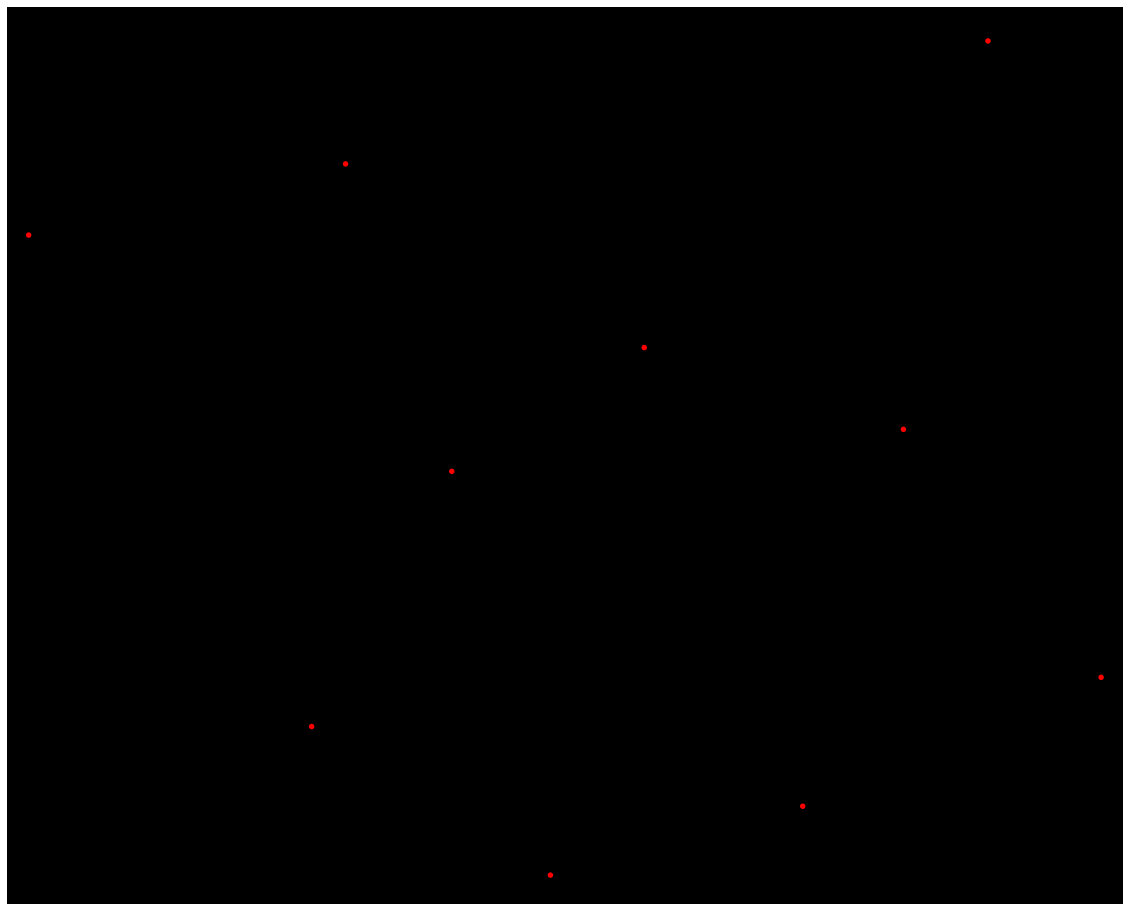

In [72]:
print_voronoi_graph(full_leeds_graph, seeds)

In [ ]:
# Calculate the node degree for each node
node_degrees = {}
for node in all_nodes:
    node_degrees[node] = len(list(G.neighbors(node)))

# Sort the nodes by degree in descending order
sorted_nodes = sorted(all_nodes, key=lambda node: node_degrees[node], reverse=True)

# Select the top num_seeds nodes by degree as the seed nodes
seeds = sorted_nodes[:NUMBER_OF_SEEDS]

# Print the seed nodes
print(seeds)

print_voronoi_graph(full_leeds_graph, seeds)

In [ ]:
# Randomly select the first seed node
seeds = [np.random.choice(all_nodes)]

# Continue randomly selecting seeds until we have enough
while len(seeds) < NUMBER_OF_SEEDS:
    # Calculate the minimum distance from each node to the existing seed nodes
    dist = {}
    for seed in seeds:
        dist[seed] = nx.single_source_dijkstra_path_length(G, seed, weight='distance')
    min_distances = np.inf * np.ones(len(all_nodes))
    for seed, d in dist.items():
        for i, node in enumerate(all_nodes):
            if node in d:
                min_distances[i] = min(min_distances[i], d[node])
    
    # Select the node with the maximum minimum distance as the next seed node
    new_seed = all_nodes[np.argmax(min_distances)]
    seeds.append(new_seed)

print_voronoi_graph(full_leeds_graph, seeds)

In [ ]:
import statistics
def optmize_voronoi(G):
    # select 10 random seeds
    seeds = list(np.random.choice(list(G.nodes()), size=10, replace=False))
    # generate Voronoi regions for each seed
    converged = False
    count = 0
    while not converged:
        regions = {}
        #for seed in seeds:

        nodes = list(G.nodes())
        distances = {seed: nx.single_source_dijkstra_path_length(G, seed, weight='length') for seed in seeds}

        for seed in seeds:
            regions[seed] = []


        for node in nodes:

            seed_distances = [(s, distances[s][node]) for s in seeds if node in distances[s]]
            seed_distances.sort(key = lambda i:i[1])

            if len(seed_distances) > 0:
                closest_seed = seed_distances[0][0]

                if closest_seed in regions.keys():
                    regions[closest_seed].append(node)
                else:
                    regions[closest_seed] = [node]

        subgraphs = {}
        # Iterate over the keys in the dictionary
        for seed in regions:
            # Create the subgraph using the nodes corresponding to the seed
            nodes = regions[seed]
            subgraph = G.subgraph(nodes)
            # Add the subgraph to the list
            subgraphs[seed] = subgraph


        spatial_data = []
        distance_data = []

        for seed in subgraphs.keys():
            total_distance = 0

            for u, v, k, data in subgraphs[seed].edges(keys=True, data=True):
                total_distance += data["length"]

            spatial_data.append((subgraphs[seed], total_distance, seed))
            distance_data.append(total_distance)
        
        if count % 2 == 0:
            spatial_data.sort(key = lambda i:i[1], reverse=True)
        else:
            spatial_data.sort(key = lambda i:i[1])


        largest_graph_seed = spatial_data[0][2]
        largest_graph = subgraphs[largest_graph_seed]

        # Extract the nodes' coordinates
        lats, lons = zip(*[(data["y"], data["x"]) for node, data in largest_graph.nodes(data=True)])

        # Calculate the centroid of the nodes' coordinates
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)

        distances_from_center = {}
        for i, node in enumerate(largest_graph.nodes):
            lat, lon = lats[i], lons[i]
            distance = haversine(center_lat, center_lon, lat, lon)
            distances_from_center[node] = distance

        # Find the node with the minimum distance to the centroid
        closest_node = min(distances_from_center, key=distances_from_center.get)

        stdev = statistics.stdev(distance_data)
        median = statistics.median(distance_data)
        
        print("Median: {}".format(median))
        print("Standard Deviation: {}".format(stdev))
        print("divisor: {}".format(stdev/median))
        

        if stdev/median < 0.24:
            converged = True
            return seeds

        seeds.remove(largest_graph_seed)
        seeds.append(closest_node)
        count += 1

In [ ]:
optmized_seeds = optmize_voronoi(G)

In [ ]:
# select 10 random seeds
seeds = list(np.random.choice(list(G.nodes()), size=10, replace=False))
# generate Voronoi regions for each seed
converged = False
count = 0
while not converged:
    regions = {}
    #for seed in seeds:

    nodes = list(G.nodes())
    distances = {seed: nx.single_source_dijkstra_path_length(G, seed, weight='length') for seed in seeds}

    for seed in seeds:
        regions[seed] = []


    for node in nodes:

        seed_distances = [(s, distances[s][node]) for s in seeds if node in distances[s]]
        seed_distances.sort(key = lambda i:i[1])

        if len(seed_distances) > 0:
            closest_seed = seed_distances[0][0]

            if closest_seed in regions.keys():
                regions[closest_seed].append(node)
            else:
                regions[closest_seed] = [node]

    subgraphs = {}
    # Iterate over the keys in the dictionary
    for seed in regions:
        # Create the subgraph using the nodes corresponding to the seed
        nodes = regions[seed]
        subgraph = G.subgraph(nodes)
        # Add the subgraph to the list
        subgraphs[seed] = subgraph

    saved_subgraph = subgraph

    converged = True

In [ ]:
saved_subgraph

In [ ]:
def find_marathons(some_subgraph):
    for node in some_subgraph.nodes():
        neighbors=some_subgraph.neighbors(node)
        for neighbor in neighbors:
            
            print(neighbor)

[(data["y"], data["x"]) for node, data in largest_graph.nodes(data=True)]

In [ ]:
find_marathons(saved_subgraph)